In [1]:
!pip install text-preprocessing

     |████████████████████████████████| 62.6 MB 5.7 MB/s eta 0:00:014
     |████████████████████████████████| 2.5 MB 8.9 MB/s eta 0:00:01
     |████████████████████████████████| 287 kB 7.3 MB/s eta 0:00:01


In [2]:
!pip install fasttext

In [3]:
!pip install gensim

In [4]:
import os
import spacy
import numpy as np 
import pandas as pd 

from text_preprocessing import preprocess_text
from text_preprocessing import to_lower, expand_contraction, remove_number,remove_special_character,normalize_unicode,remove_punctuation,remove_stopword,check_spelling
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

import fasttext
from gensim.models import Word2Vec
from tqdm.notebook import tqdm



tqdm.pandas()
load_model = spacy.load('en_core_web_sm', disable = ['parser','ner'])

[nltk_data] Downloading package omw-1.4 to /Users/denis/nltk_data...


In [6]:
data = pd.read_csv('/Users/denis/Downloads/movie.csv')
data.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [7]:
data.label.value_counts()

0    20019
1    19981
Name: label, dtype: int64

In [8]:
def clean_data(text_pro):
    text_pro = text_pro.replace('br','')
    doc = load_model(text_pro)
    text = " ".join([token.lemma_ for token in doc])
    preprocess_functions = [to_lower,remove_special_character,remove_number,normalize_unicode,remove_punctuation, expand_contraction,remove_stopword]
    preprocessed_text = preprocess_text(text_pro, preprocess_functions)
    return preprocessed_text

In [9]:
df = data.copy()

df['text'] = df['text'].progress_apply(clean_data)

  0%|          | 0/40000 [00:00<?, ?it/s]

In [10]:
X = df.text
y = df.label

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# Bag of Words

In [11]:
vect = CountVectorizer(max_features = 10000)

X_train_dm = vect.fit_transform(X_train)
X_test_dm = vect.transform(X_test)

In [12]:
X_train_dm.shape

(32000, 10000)

In [13]:
classifier = MultinomialNB()
classifier.fit(X_train_dm,y_train)

MultinomialNB()

In [14]:
predictions = classifier.predict(X_test_dm)

In [15]:
def evaluate_performance(y_true,predictions):
    #accuracy_score
    print(f"Accuracy : {accuracy_score(y_true,predictions,normalize=True) * 100} \n")
    
    #confusion matrix
    cm = confusion_matrix(y_true,predictions)
    ax = sns.heatmap(cm/np.sum(cm),fmt='.2%',annot=True,cmap='Blues')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')

    ax.xaxis.set_ticklabels(['Negative','Positive'])
    ax.yaxis.set_ticklabels(['Negative','Positive'])
    plt.show();
    
    print('\n')
    #classification_report
    print(f"Classification report : \n{classification_report(y_true,predictions,target_names=['Negative','Positive'])}")
    
    

Accuracy : 84.98750000000001 



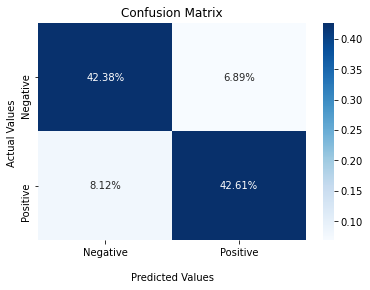



Classification report : 
              precision    recall  f1-score   support

    Negative       0.84      0.86      0.85      3941
    Positive       0.86      0.84      0.85      4059

    accuracy                           0.85      8000
   macro avg       0.85      0.85      0.85      8000
weighted avg       0.85      0.85      0.85      8000



In [16]:
evaluate_performance(y_test,predictions)

In [17]:
X_train.shape

(32000,)

In [18]:
statement = "The movie was totally boring. The story was dull and the editor did a horrible job at editing this movie. Should have left the jumps and scares instead of cutting it off when the time came."
st_dm = vect.transform([statement])
classifier.predict(st_dm)[0]

0

In [19]:
statement = "I could watch an entire 2.5 hour long movie about just the 3 spideys fighting villains. but the rest of the movie was good too. Something in my heart was made right seeing Andrew and Tobey in their suits again. love this movie."
st_dm = vect.transform([statement])
classifier.predict(st_dm)[0]

0

In [20]:
statement = "I loved the way all the Spider-Man movies were pulled into 1 story. I also loved how Spider-Man saved all his villians"
st_dm = vect.transform([statement])
classifier.predict(st_dm)[0]

1

Accuracy : 86.5625 



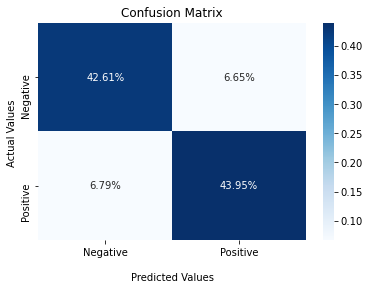



Classification report : 
              precision    recall  f1-score   support

    Negative       0.86      0.87      0.86      3941
    Positive       0.87      0.87      0.87      4059

    accuracy                           0.87      8000
   macro avg       0.87      0.87      0.87      8000
weighted avg       0.87      0.87      0.87      8000



In [21]:
logreg_classifier = LogisticRegression(class_weight='balanced',solver='liblinear')
logreg_classifier.fit(X_train_dm,y_train)
predictions = logreg_classifier.predict(X_test_dm)
evaluate_performance(y_test,predictions)

Accuracy : 85.6875 



/Users/denis/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


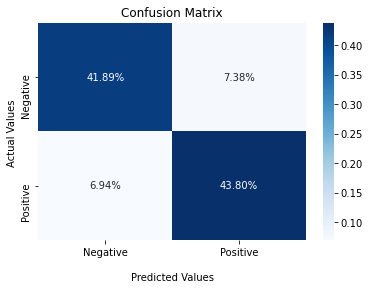



Classification report : 
              precision    recall  f1-score   support

    Negative       0.86      0.85      0.85      3941
    Positive       0.86      0.86      0.86      4059

    accuracy                           0.86      8000
   macro avg       0.86      0.86      0.86      8000
weighted avg       0.86      0.86      0.86      8000



In [22]:
vect = CountVectorizer(max_features = 1000)

X_train_dm = vect.fit_transform(X_train)
X_test_dm = vect.transform(X_test)

svm_classifier = LinearSVC()
svm_classifier.fit(X_train_dm,y_train)
predictions = svm_classifier.predict(X_test_dm)
evaluate_performance(y_test,predictions)

In [23]:
statement = "The movie was totally boring. The story was dull and the editor did a horrible job at editing this movie. Should have left the jumps and scares instead of cutting it off when the time came."
st_dm = vect.transform([statement])
svm_classifier.predict(st_dm)[0]

0

In [24]:
statement = "I loved the way all the Spider-Man movies were pulled into 1 story. I also loved how Spider-Man saved all his villians"
st_dm = vect.transform([statement])
svm_classifier.predict(st_dm)[0]

1

In [25]:
statement = "I could watch an entire 2.5 hour long movie about just the 3 spideys fighting villains. but the rest of the movie was good too. Something in my heart was made right seeing Andrew and Tobey in their suits again. love this movie."
st_dm = vect.transform([statement])
svm_classifier.predict(st_dm)[0]

1

## Fasttext

In [48]:
def add_label(df):
    rows = []
    for row in df.iterrows():
        if row[1][1] == 0:
            text = ' __label__negative '
        else:
            text = ' __label__positive'
        row[1][0] += row[1][0] + text
        rows.append(row[1][0])
    df = pd.DataFrame({'text':rows})    
    return df

In [49]:
df_1= df.copy()
df_1 = add_label(df_1)

In [50]:
X_train,X_test = train_test_split(df_1,test_size=0.2,random_state=0)

In [51]:
train_file = './train.csv'
X_train.to_csv(train_file, header=None, index=False, columns=['text'] )

test_file = './test.csv'
X_test.to_csv(test_file, header=None, index=False, columns=['text'])

In [52]:
model = fasttext.train_supervised(input=train_file,lr=1.0, epoch=75, loss='hs', wordNgrams=2, dim=200, thread=2, verbose=100)

In [53]:
model.labels

['__label__negative', '__label__positive']

In [54]:
results = model.test(test_file)

In [55]:
print(f"Test Samples: {results[0]} Precision : {results[1]*100:2.4f} Recall : {results[2]*100:2.4f}")

Test Samples: 8000 Precision : 89.2500 Recall : 89.2500


In [56]:
statement = "The movie was totally boring. The story was dull and the editor did a horrible job at editing this movie. Should have left the jumps and scares instead of cutting it off when the time came."
model.predict(statement)

(('__label__negative',), array([1.00001001]))

In [57]:
statement = "I loved the way all the Spider-Man movies were pulled into 1 story. I also loved how Spider-Man saved all his villians"
model.predict(statement)

(('__label__positive',), array([1.00001001]))

In [58]:
statement = "I could watch an entire 2.5 hour long movie about just the 3 spideys fighting villains. but the rest of the movie was good too. Something in my heart was made right seeing Andrew and Tobey in their suits again. love this movie."
model.predict(statement)

(('__label__positive',), array([0.99074477]))

In [ ]:
# the model correctly assessed the reviews